In [1]:
%matplotlib inline
import ipykernel
import numpy as np
from astropy.io import fits
import astropy.units as units
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rc
from scipy.interpolate import interp1d
from scipy import stats

from statistics import mode

from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from sklearn.mixture import GMM


In [9]:
rc('text', usetex= True)
rc('font', family='serif', weight = 'normal', size=20)
rc('xtick.major', size='6')
rc('xtick.minor', size='4')
rc('ytick.major', size='6')
rc('ytick.minor', size='4')
rc('lines', linewidth=1.5)
rc('axes', linewidth=1.5)
rc('axes', facecolor='f9f9f9')
rc('axes', axisbelow=True)
rc('xtick', direction='in')
rc('ytick', direction='in')
rc('grid', color='cbcbcb')
rc('grid', linestyle='--')
rc('grid', linewidth=0.5)
rc('grid', alpha=1.0)
rc('figure', facecolor='ffffff')
rc('figure', dpi=80)
rc('figure.subplot', bottom=0.125)


In [23]:
path = '/data1/Data/PanSTARRS/'
pan = fits.open(path + 'panstarrsErrcutNgt50.fits')
pan = pan[1].data

In [24]:
l = pan['l']
b = pan['b']
xmin, xmax = 190.,220.
ymin, ymax = -28.,-10.

X = np.vstack([l, b]).T
deg2rad = np.pi/180.

X = X*deg2rad

kde = KernelDensity(kernel='gaussian', bandwidth=0.3*deg2rad, metric = 'haversine').fit(X)

Xsamples = np.linspace(xmin, xmax, 300)
Ysamples = np.linspace(ymin, ymax, 180)
X,Y = np.meshgrid(Xsamples, Ysamples)
grid = np.vstack([X.ravel(), Y.ravel()]).T 
grid = grid*deg2rad

log_dens_field = kde.score_samples(grid).T
log_dens_field = log_dens_field.reshape(X.shape)


Above I am requiring the numbers of detection to be larger than 50.

### Stars in the field I am considering
N = 5 877 616

### Select young sources

Same procedure as with the Gaia data, but slightly different photometric selection (different bands).
The red line is used to select the young sources.

[-0.5, 2.5, 24, 12]

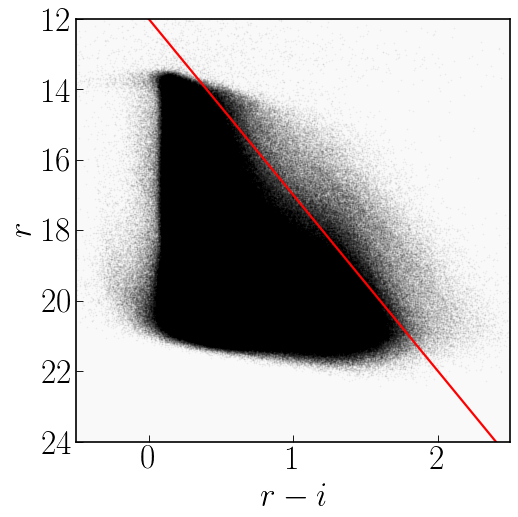

In [4]:
plt.figure(figsize=(7, 7))

#plt.plot(preliminaryA['rMeanPSFMag']- preliminaryA['iMeanPSFMag'], preliminaryA['rMeanPSFMag'], 
#        'ko', ms = 0.03)

### *ALL*
plt.plot(pan['rMeanPSFMag']- pan['iMeanPSFMag'], pan['rMeanPSFMag'], 
            'ko', ms = 0.03)


x = np.linspace(-0.5, 2.5, 100)
y = 5*x + 12.

plt.plot(x, y, 'r-', lw =2)
plt.xlabel(r'$r-i$')
plt.ylabel(r'$r$')
plt.axis([-0.5, 2.5, 24, 12])


In [134]:
w_preliminaryA = np.where((pan['rMeanPSFMag'] <  5.*(pan['rMeanPSFMag']-pan['iMeanPSFMag']) + 12.))
preliminaryA = pan[(w_preliminaryA)] 

In [141]:
fits.writeto('/data1/Data/PanSTARRS/preliminarySelectionA.fits', preliminaryA, overwrite=True)

In [142]:
print('Number of sources selected:', len(preliminary))

Number of sources selected: 104438


In [5]:
preliminaryHDU = fits.open(path + 'preliminarySelectionA.fits')
preliminary = preliminaryHDU[1].data

[219.9, 190, -28, -10]

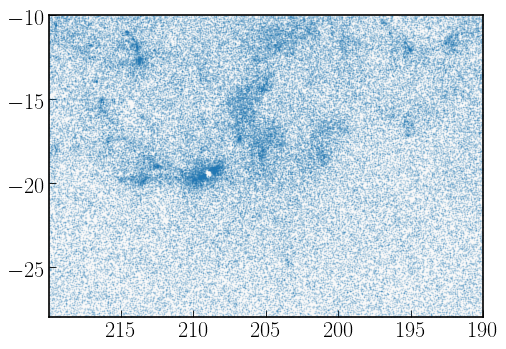

In [10]:
plt.figure(figsize=(7, 5))
plt.plot(preliminary['l'], preliminary['b'], 'o', ms = 0.1)
plt.axis([219.9, 190, -28, -10])

### Cross-Match with 2MASS

This is done (as when analysing the Gaia data) to exclude reddened sources.

In [12]:
hduTest = fits.open('/data1/Data/PanSTARRS/XMatch_preliminaryA_2MASS.fits')

In [13]:
test = hduTest[1].data

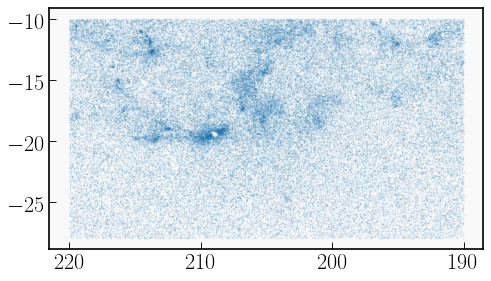

In [14]:
plt.figure(figsize=(7, 4))
plt.plot(test['l'], test['b'], '.', ms= 0.1)
plt.gca().invert_xaxis()

I use the same 2MASS photometric filtering as in Gaia.

In [15]:
photo = ((test['Jmag'] - test['Hmag']) < -1.05*(test['Hmag'] - test['Kmag']) + 0.97) & \
            (test['Jmag'] < 15.) & (test['Jmag'] - test['Hmag'] < 0.74) & \
            (test['Hmag'] - test['Kmag'] > -0.2)  & \
            (test['Hmag'] - test['Kmag'] < 0.43 )             
test_ic = test[photo]

In [16]:
print('Number of sources:', len(test_ic))

Number of sources: 54744


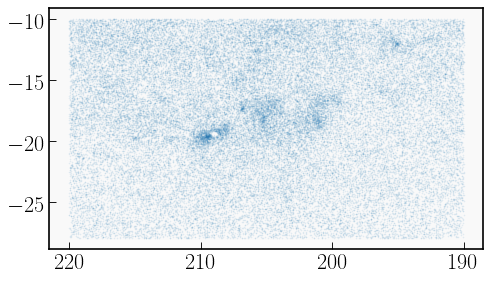

In [17]:
plt.figure(figsize=(7, 4))
plt.plot(test_ic['l'], test_ic['b'], '.', ms= 0.1)
plt.gca().invert_xaxis()

## KDE 

Of the young sources.


In [18]:
l = test_ic['l']
b = test_ic['b']
xmin, xmax = 190.,220.
ymin, ymax = -28.,-10.

XP = np.vstack([l, b]).T
deg2rad = np.pi/180.

XP = XP*deg2rad

kde = KernelDensity(kernel='gaussian', bandwidth=0.3*deg2rad, metric = 'haversine').fit(XP)

Xsamples = np.linspace(xmin, xmax, 300)
Ysamples = np.linspace(ymin, ymax, 180)
X,Y = np.meshgrid(Xsamples, Ysamples)
grid = np.vstack([X.ravel(), Y.ravel()]).T 
grid = grid*deg2rad

log_dens_fieldP = kde.score_samples(grid).T
log_dens_fieldP = log_dens_fieldP.reshape(X.shape)


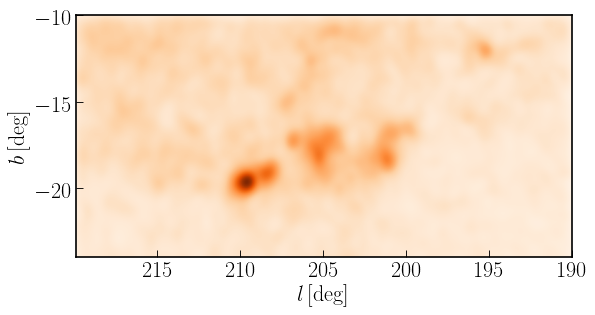

In [19]:
fig = plt.figure(figsize=(8,4))
xmin, xmax = 190., 220.
ymin, ymax = -28., -10.

im = plt.imshow(np.exp(log_dens_fieldP), cmap=plt.cm.Oranges,
          extent=[xmin, xmax, ymin, ymax], aspect = 'auto',
          origin = 'lower', interpolation = 'gaussian')

plt.axis([219.9, 190, -24, -10])
plt.xlabel(r'$l \, \mathrm{[deg]}$', fontsize = 20)
plt.ylabel(r'$b \, \mathrm{[deg]}$', fontsize = 20)


plt.show()


### Compute the variance and select the sources within the 2$\sigma$ levels

In [25]:
mean_density_per_latitude = np.tile(np.exp(log_dens_field).mean(1), (Xsamples.size, 1)).T
stdv_density_per_latitude = np.tile(np.exp(log_dens_field).std(1), (Xsamples.size, 1)).T
normalized_density = (np.exp(log_dens_fieldP) - mean_density_per_latitude)/stdv_density_per_latitude 

[219.9, 190.0, -28.0, -10]

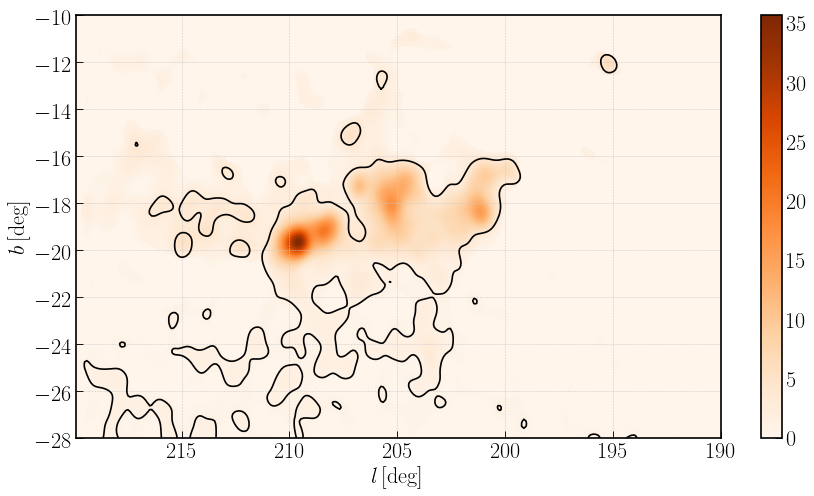

In [26]:
plt.figure(figsize=(13, 7))
xmin, xmax = 190., 220.
ymin, ymax = -28., -10.

im = plt.imshow(np.exp(log_dens_fieldP)- mean_density_per_latitude, cmap=plt.cm.Oranges,
          extent=[xmin, xmax, ymin, ymax], aspect = 'auto',
          origin = 'lower', interpolation = 'gaussian', vmin = 0.)

twoSigma = plt.contour(normalized_density, 
            cmap = plt.cm.gray,
            extent=[xmin, xmax, ymin, ymax],
            levels = [2.], lw = 1)

#plt.plot(lIn2, bIn2, 'ko', ms = 0.1)
plt.xlabel(r'$l \, \mathrm{[deg]}$', fontsize = 20)
plt.ylabel(r'$b \, \mathrm{[deg]}$', fontsize = 20)

plt.grid()
plt.colorbar(im)
plt.axis([219.9, 190., -28., -10])


### Select the sources in the overdensities using the significance map

In [27]:
XP = np.vstack([test_ic['l'],test_ic['b']]).T
inside_contour = np.full((test_ic['l'].size), False, dtype= bool)
for coll in twoSigma.collections:
    for p in coll.get_paths():
        inside_contour  = inside_contour | p.contains_points(XP)

In [28]:
testIn = test_ic[inside_contour]

In [29]:
print('Number of selected sources: ', len(testIn))

Number of selected sources:  12753


In [ ]:
#fits.writeto(path + 'panInSiggt2_A.fits', testIn, overwrite = True)

## Bayes IsoFit Pan-Starrs

With constant parallax. Same fit as with the Gaia sources.

In [ ]:
hdu = fits.open(path+ 'panInSiggt2_A.fits')
panGaiaIn = hdu[1].data

In [ ]:
isochrone = '../IsoFit/panstarrsAv025Z002.fits'

ages = np.arange(6., 8.5, 0.01)
plxi = 2.65
d = 1000./plxi
mu = 5*np.log10(d) - 5
rAbsStar = panGaiaIn['rMeanPSFMag'] - mu
rminiStar = panGaiaIn['rMeanPSFMag']-panGaiaIn['iMeanPSFMag']
sigmarmag = panGaiaIn['rMeanPSFMagErr']
sigmarmini = np.sqrt( (panGaiaIn['rMeanPSFMagErr'])**2. + (panGaiaIn['iMeanPSFMagErr'])**2.)
gfSmoothi2, gfi2 = determineClusterAge(rAbsStar, rminiStar, sigmarmag, sigmarmini,
                                             isochrone, ages)

Ages

In [ ]:
singleAgesi = np.zeros(len(gfi2))
l, b, sourceId = np.zeros(len(gfi2)), np.zeros(len(gfi2)),np.zeros(len(gfi2))
count2 = []
for i in range(len(gfi2)):
        try:
            singleAgesi[i] = ages[np.where(gfi2[i] == np.max(gfi2[i]))]
            l[i] = panGaiaIn['l'][i]
            b[i] = panGaiaIn['b'][i]
            sourceId[i] = panGaiaIn['objID'][i]
        except ValueError:
            #print("Value Error at star:", i, "when computing singleAge")
            count2.append(panGaiaIn['objID'][i])
            pass

In [ ]:
gfiNorm = np.zeros((len(gfi2), len(ages)))
for i in range(len(gfi2)):
    gfiNorm[i, :] = gfSmoothi2[i, :]/np.max(gfSmoothi2[i, :])
    
indxGood, indxGood2, indxBad, x1, x2 = computeGoodG(gfiNorm, ages)

In [61]:
print('Well determined ages:', len(singleAgesi[indxGood])

11971

In [ ]:
path = '../../../../../data1/Data/PanSTARRS/ResultsBayesFit/'
filename = 'resultsBayesFitPanZ002_Av025Plx2.65_GoodA.fits'

colAges = fits.Column(name='ages', format='D', array= singleAgesi[indxGood])
colL = fits.Column(name='l', format='D', array= panGaiaIn['l'][indxGood])
colB = fits.Column(name='b', format='D', array= panGaiaIn['b'][indxGood])
colID  = fits.Column(name='sourceId', format='K', array= panGaiaIn['objID'][indxGood])

cols = fits.ColDefs([colL, colB, 
                     colID, colAges])
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto(path + filename, overwrite =True)

filename = 'resultsBayesFitPanZ002_Av025Plx2.65_BadA.fits'

colAges = fits.Column(name='ages', format='D', array= singleAgesi[indxBad])
colL = fits.Column(name='l', format='D', array= panGaiaIn['l'][indxBad])
colB = fits.Column(name='b', format='D', array= panGaiaIn['b'][indxBad])
colID  = fits.Column(name='sourceId', format='K', array= panGaiaIn['objID'][indxBad])

cols = fits.ColDefs([colL, colB, 
                     colID, colAges])
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto(path + filename, overwrite =True)

In [ ]:
path = '../../../../../data1/Data/PanSTARRS/'
hduAll = fits.open(path + 'panInSiggt2_A.fits')
dataAll = hduAll[1].data

path = '../../../../../data1/Data/PanSTARRS/ResultsBayesFit/'
filename2 = 'resultsBayesFitPanZ002_Av025Plx2.65_BadA.fits'
filename1 = 'resultsBayesFitPanZ002_Av025Plx2.65_GoodA.fits'
hduG = fits.open(path + filename1)
hduB = fits.open(path + filename2)
dataFitG = hduG[1].data
dataFitB = hduB[1].data

isochrone = '../IsoFit/panstarrsAv025Z002.fits'
isohdu = fits.open(isochrone)
isoage = [6.0, 6.7, 7., 7.3]  


indxG = dataFitG['sourceId']
ageG = dataFitG['ages']
indxB = dataFitB['sourceId']
ageB = dataFitB['ages']

indxall = dataAll['objID']
dataCommonG = np.in1d(indxall, indxG)
dataCommonB = np.in1d(indxall, indxB)

rmini = dataAll['rMeanPSFMag']-dataAll['iMeanPSFMag']
rmag = dataAll['rMeanPSFMag']

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(rmini[dataCommonG][ageG <= 7.3],
         rmag[dataCommonG][ageG <= 7.3],
         'ko', ms =0.5, markeredgecolor = 'None')
plt.plot(rmini[dataCommonB], rmag[dataCommonB], '+', 
         color = 'r', ms =16, mew = 0.3, alpha =1)
plt.axis([-0.2, 2.5, 20., 12])
plt.xlabel(r'$G-J \, \mathrm{[mag]}$', fontsize = 20)
plt.ylabel(r'$G \, \mathrm{[mag]}$', fontsize = 20)
plt.tight_layout()


Age Maps

In [193]:
path = '/data1/Data/PanSTARRS/ResultsBayesFit/'
filename = 'resultsBayesFitPanZ002_Av025Plx2.65_GoodA.fits'
hdu = fits.open(path + filename)
data = hdu[1].data
l, b, sourceId, singleAges = data['l'], data['b'], data['sourceId'], data['ages']


In [194]:
lSel, bSel = dict(), dict()
sourceIdSel = dict()
log_dens_fieldi = dict()

ageBinsyrs = np.array([1.,3.,  5., 7., 9, 11., 13, 15.,20., 200])*10**6.
ageBins = np.log10(ageBinsyrs)


for i in range(len(ageBins)-1):
        w = np.where((singleAges >= ageBins[i]) & (singleAges < ageBins[i+1]))
        print(len(l[w]))
        lSel[i], bSel[i] = l[w], b[w]
        sourceIdSel[i] = sourceId[w]
        xmin, xmax = 190.,220.
        ymin, ymax = -28.,-10.

        X = np.vstack([lSel[i], bSel[i]]).T
        deg2rad = np.pi/180.
        X = X*deg2rad

        kde = KernelDensity(kernel='gaussian', bandwidth=0.3*deg2rad).fit(X)

        Xsamples = np.linspace(xmin, xmax, 300)
        Ysamples = np.linspace(ymin, ymax, 180)
        X,Y = np.meshgrid(Xsamples, Ysamples)
        grid = np.vstack([X.ravel(), Y.ravel()]).T 
        grid = grid*deg2rad
        log_dens_fieldi[i]= kde.score_samples(grid).T
        log_dens_fieldi[i] = log_dens_fieldi[i].reshape(X.shape)
    

    
    

1390
1241
1242
1318
916
678
548
930
4255


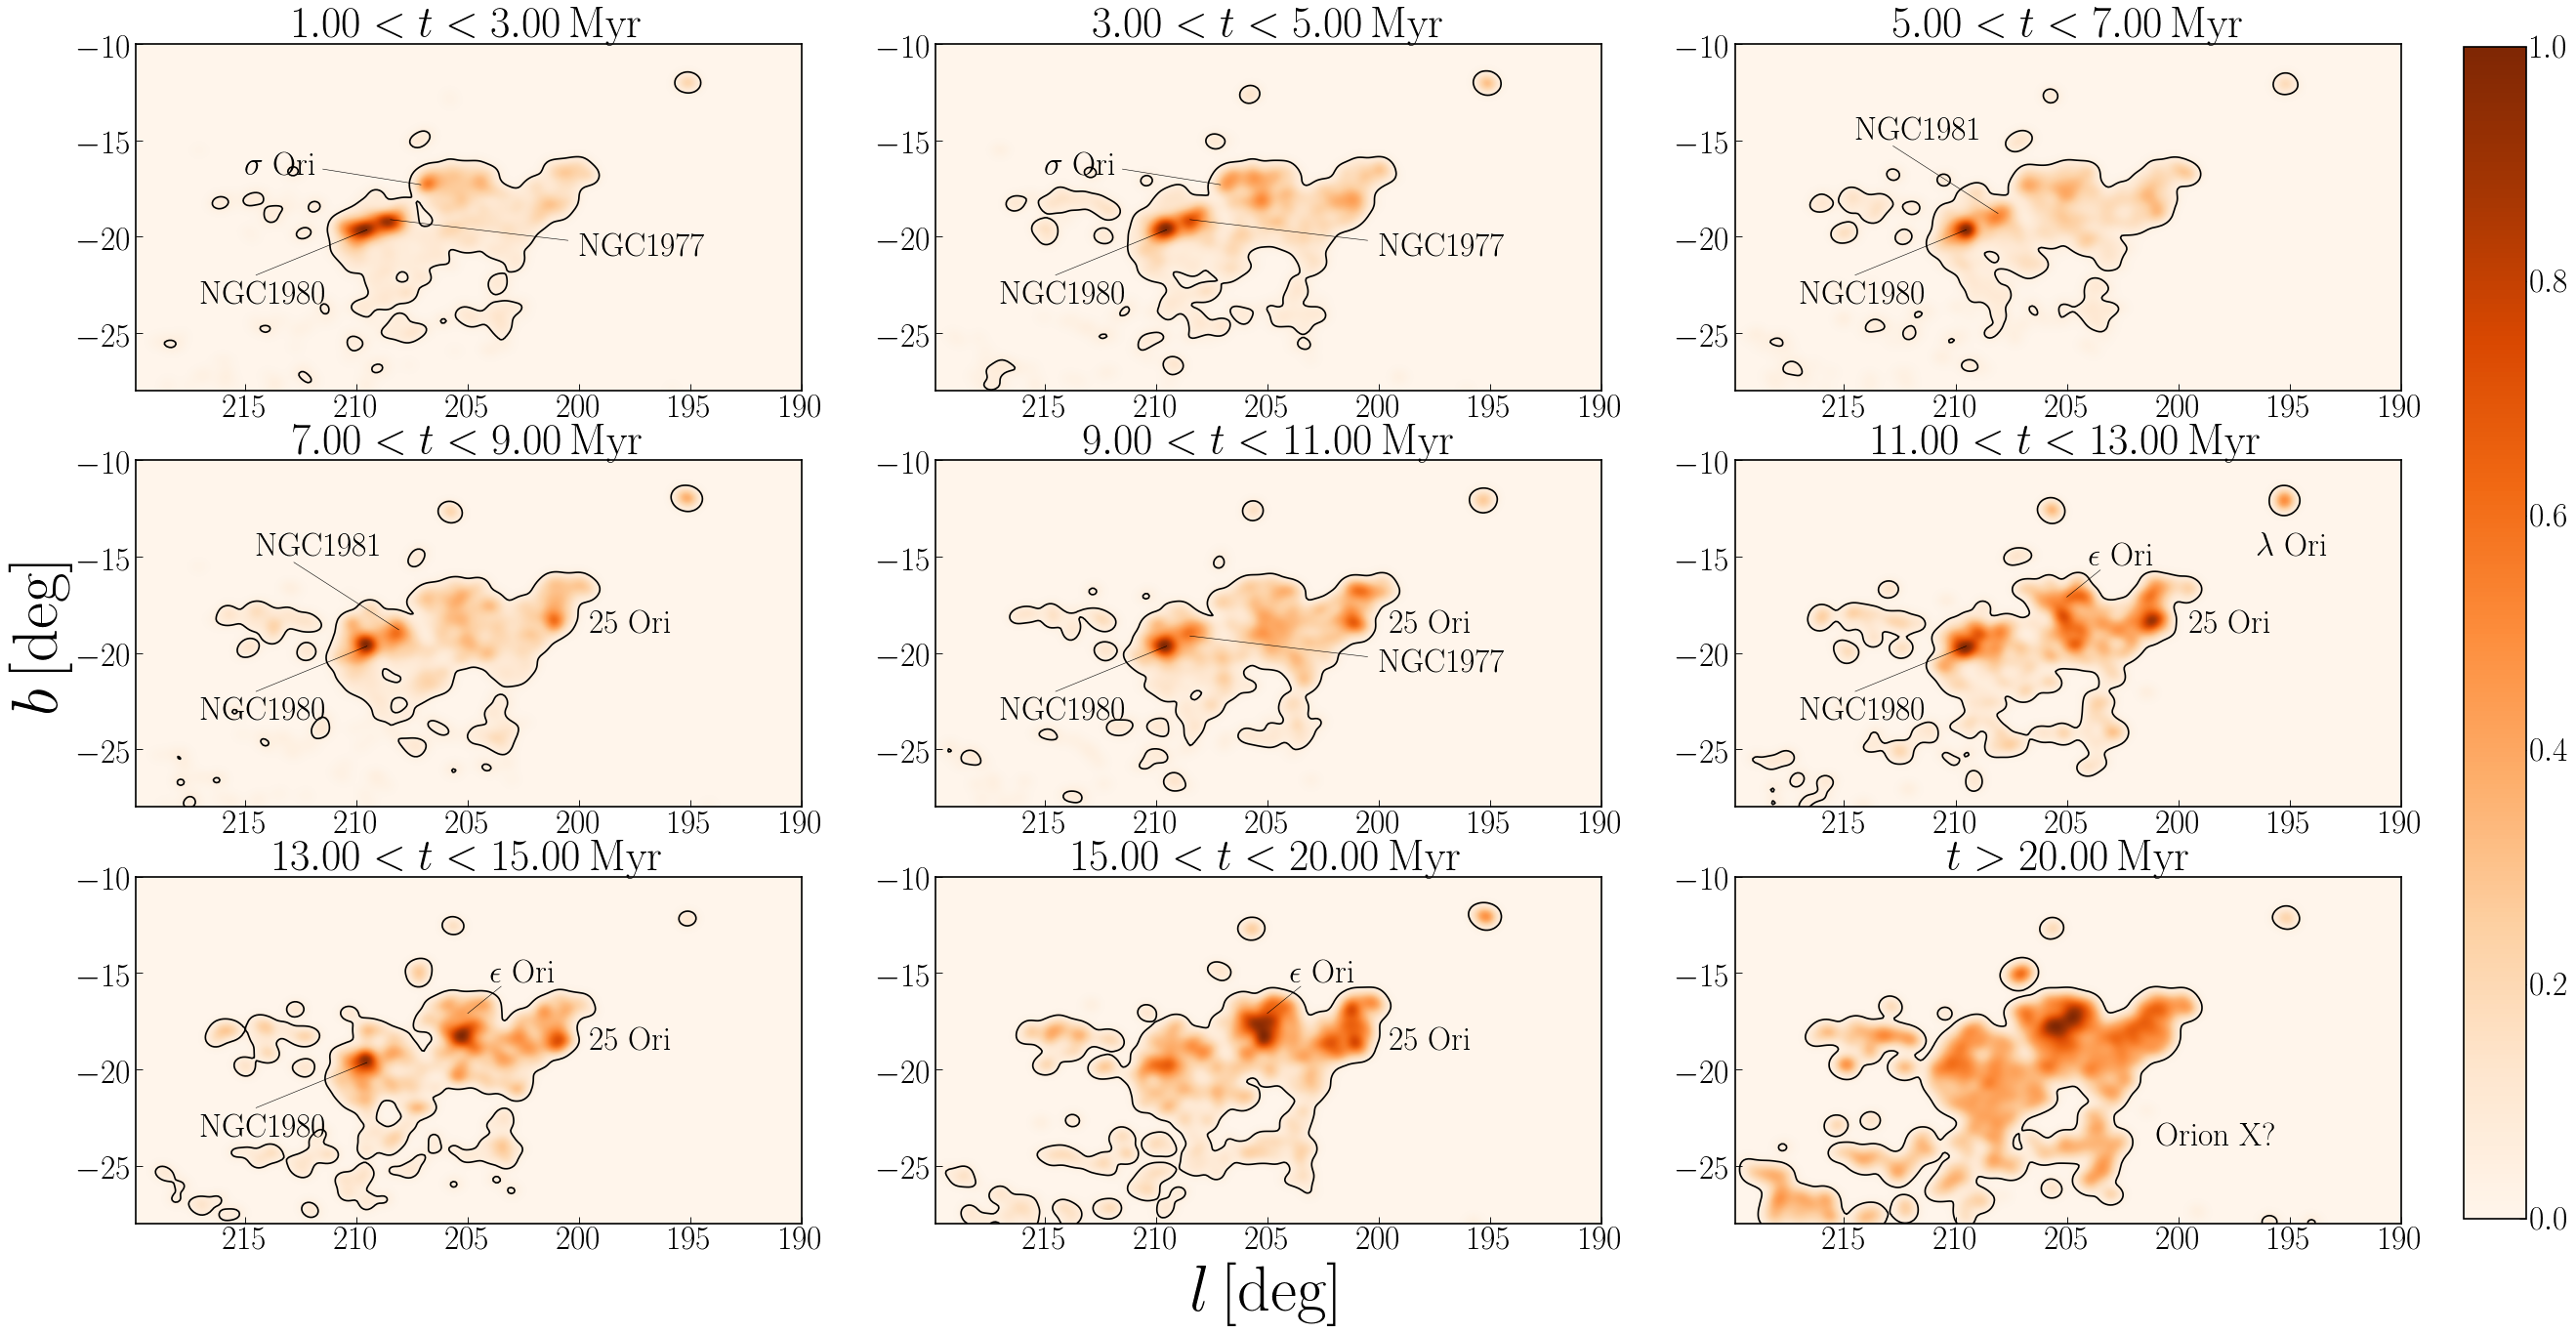

In [195]:
rc('font', family='serif', weight = 'normal', size=30)


fig = plt.figure(figsize=(40, 20))

for a in range(len(ageBins)-1):
    
    plt.subplot(3,3,a+1)
    im = plt.imshow(np.exp(log_dens_fieldi[a])/np.max(np.exp(log_dens_fieldi[a])),
                    cmap=plt.cm.Oranges,
                  extent=[xmin, xmax, ymin, ymax], aspect = 'auto',
                  origin = 'lower', interpolation = 'gaussian')
    plt.contour(np.exp(log_dens_fieldi[a])/np.max(np.exp(log_dens_fieldi[a])),
            cmap = plt.cm.gray,
            extent=[xmin, xmax, ymin, ymax],
            levels = [0.05], lw = 1)
    if a == 3:
        plt.ylabel(r'$b \, \mathrm{[deg]}$', fontsize = 60)
    elif a == 7:
        plt.xlabel(r'$l \, \mathrm{[deg]}$', fontsize = 60)
    
    if a <= 7:
        plt.title(r' $%.2f < t  < %.2f \, \mathrm{Myr}$ ' %(10**ageBins[a]/10**6., 10**ageBins[a+1]/10**6), 
             fontsize = 40) 
    elif a ==8:
        plt.title(r' $ t  > %.2f \, \mathrm{Myr}$ ' %(10**ageBins[a]/10**6.), 
             fontsize = 40)     
    
    plt.axis([219.9, 190, -22, -10])
    
    plt.axis([219.9, 190, -28, -10])
    
    if a == 0:
        plt.text(200, -21 , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([200.5, 208.47], [-20.2, -19.12], 'k-', lw = 0.5)
        plt.text(217., -23.5, 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([214.5, 209.52], [-22, -19.65], 'k-', lw = 0.5)
        plt.text(215, -16.8, '$\mathrm{\sigma}$ Ori', color = 'k',fontsize = 30, family ='sans-serif')
        plt.plot([211.5, 207.1], [-16.5, -17.31], 'k-', lw = 0.5)

        
        
    if (a == 1):
        plt.text(217., -23.5, 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([214.5, 209.52], [-22, -19.65], 'k-', lw = 0.5)
        plt.text(200, -21 , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([200.5, 208.47], [-20.2, -19.12], 'k-', lw = 0.5)
        plt.text(215, -16.8, '$\mathrm{\sigma}$ Ori', color = 'k',fontsize = 30, family ='sans-serif')
        plt.plot([211.5, 207.1], [-16.5, -17.31], 'k-', lw = 0.5)

        
    if (a==2):
        plt.text(214.5, -15., 'NGC1981', fontsize = 30, family ='sans-serif')
        plt.plot([212.8, 208.09], [-15.3, -18.8 ], 'k-', lw =0.5)
        plt.text(217., -23.5, 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([214.5, 209.52], [-22, -19.65], 'k-', lw = 0.5)
        
        
        
    if (a == 3):
        plt.text(217., -23.5, 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([214.5, 209.52], [-22, -19.65], 'k-', lw = 0.5)
        plt.text(214.5, -15., 'NGC1981', fontsize = 30, family ='sans-serif')
        plt.plot([212.8, 208.09], [-15.3, -18.8 ], 'k-', lw =0.5)
        plt.text(199.5, -19, '25 Ori', fontsize = 30, family ='sans-serif')
    
    if (a == 4):
        plt.text(217., -23.5, 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([214.5, 209.52], [-22, -19.65], 'k-', lw = 0.5)
        plt.text(199.5, -19, '25 Ori', fontsize = 30, family ='sans-serif')
        plt.text(200, -21 , 'NGC1977', fontsize = 30, family ='sans-serif')
        plt.plot([200.5, 208.47], [-20.2, -19.12], 'k-', lw = 0.5)
        
    
    
    if (a == 5):
        plt.text(217., -23.5, 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([214.5, 209.52], [-22, -19.65], 'k-', lw = 0.5)
        plt.text(199.5, -19, '25 Ori', fontsize = 30, family ='sans-serif')
        plt.text(204., -15.5, '$\mathrm{\epsilon}$ Ori', fontsize = 30, family ='sans-serif')
        plt.plot([203.5, 205.],[-15.7, -17.1], 'k-', lw = 0.5)
        plt.text(196.5, -15. , '$\mathrm{\lambda}$ Ori', fontsize = 30, family ='sans-serif')
        

    if (a == 6):
        plt.text(217., -23.5, 'NGC1980', fontsize = 30, family ='sans-serif')
        plt.plot([214.5, 209.52], [-22, -19.65], 'k-', lw = 0.5)
        plt.text(199.5, -19, '25 Ori', fontsize = 30, family ='sans-serif')
        plt.text(204., -15.5, '$\mathrm{\epsilon}$ Ori', fontsize = 30, family ='sans-serif')
        plt.plot([203.5, 205.],[-15.7, -17.1], 'k-', lw = 0.5)
        
    if (a==7):
        plt.text(199.5, -19, '25 Ori', fontsize = 30, family ='sans-serif')
        plt.text(204., -15.5, '$\mathrm{\epsilon}$ Ori', fontsize = 30, family ='sans-serif')
        plt.plot([203.5, 205.],[-15.7, -17.1], 'k-', lw = 0.5)
        
    if (a==8):
        plt.text(201, -24. , 'Orion X?', fontsize = 30, family ='sans-serif')
        
rc('text', usetex= True)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.128, 0.02, 0.75])
fig.colorbar(im, cax=cbar_ax)

## Functions

In [57]:
### PURPOSE:
### Collection of functions to be used to perform a Bayesian isochrone fitting
### based on Jorgensen & Lindegren (2005).
### E.Z. Jan 2016



import numpy as np
from astropy.io import fits
import astropy.units as units
from astropy.coordinates import SkyCoord
from scipy import stats
from scipy.interpolate import interp1d
from scipy import stats
from statistics import mode


def likelihood(mag_obs, mag_teor, sigma_mag, color_obs, color_teor,  sigma_color):
    
    """
    Likelihood function for a single star:
    
    Parameters:
    -------------
    mag_obs, color_obs - observed magnitude and color; 
    mag_teor, color_teor - array with predicted magnitude and color values; Note that 
                           mag_teor=mag_teor(m)
    sigma_mag, sigma_color -  error on magnitude and color;
    
    Returns:
    ----------
    l - array with the likelihood function for one  star at fixed time and metallicity;
    
    """
    

  
    chisquared = np.zeros(len(mag_teor))
    l = np.zeros(len(mag_teor))
    for i in range(len(mag_teor)):
        chisquared[i] = ((mag_obs - mag_teor[i])/sigma_mag)**2. + \
                        ((color_obs - color_teor[i])/sigma_color)**2
        l[i] = (2.*np.pi*sigma_mag*sigma_color)**(-1)*np.exp(-chisquared[i]/2.)
        
        
        
    return l


def massprior(m):
    """
    Prior on the underlying mass distribution.
    
    Parameters:
    ------------
    m - array with the isochrone initial masses (units M_{\odot}) 
    
    Returns:
    
    mp - prior (Kroupa IMF with a = -2.7 (this is true for M > 1 M_{\odot}))
    
    """
    
    A = 1.
    a = 2.7
    mp = A*m**(-a)
    
    return mp




def Gfunc(m, mag_obs, mag_teor, sigma_mag, color_obs, color_teor, sigma_color):
    """
    Parameters:
    ------------
    m - array of the initial masses of the isochrone at a fixed time;
    Other parameters defined above.

    
    Returns:
    ------------
    G(t_j) as defined in equation 11 of Jorgensen and Lindegren (2005),
    without any dependency on the metallicity.
    """

    l = likelihood(mag_obs, mag_teor, sigma_mag, color_obs, color_teor, sigma_color)
    G = np.zeros(len(m))
   
    for i in range(len(m)-2):
        mp = massprior(m[i+1])
        G[i] = l[i+1]*mp*(m[i+2]-m[i])
        
    return np.sum(G)
    


    

def computeGoodG(gfNormalized, age):
    """
    Parameters:
    -------------
    gfNormalized - array with the normalized G functions;
    age - isochrone ages
    
    Returns:
    -------------
    indexesGood, indexesBad - indexes of the "well-behaved" ("bad-behaved")
                              g-functions;
    
    
    """
    
    
    Glim = 0.6
    indexesGood, indexesGood2, indexesBad = [], [], []
    x1, x2 = [],[]
   
    for i in range(len(gfNormalized)):
        #print(i)
        
        function = interp1d(age, gfNormalized[i, :])
        n = 1000
        x = np.linspace(min(age), max(age), n)
        y = function(x)
        
        w = np.where(function(x) > Glim)
        x = x[w]
        y = y[w]
        
        try:
            indx = np.argmax(y)
            if (indx == len(y)-1) or (indx == 0):
                indexesBad.append(i)

            else:    
        
                ii = indx
                while y[ii + 1] < y[ii]:
                    indxmin1 = ii
                    ii += 1
                    if ii == len(y)-1:
                        break


                iii = indx 
                while y[iii-1] < y[iii]:
                    indxmin2 = iii
                    iii = iii -1
                    if iii == 0:
                        break

                xmax = x[indxmin1]
                xmin = x[indxmin2]

                x1.append(xmax)
                x2.append(xmin)

                eps = np.sqrt(xmax/xmin) - 1.

                if  (eps < 0.2):
                    indexesGood.append(i)
                elif (eps > 0.2):
                    indexesGood2.append(i)

        except ValueError:
            indexesBad.append(i)
            print("Value Error at star:", i)
            pass
        
        
            
            
    return indexesGood, indexesGood2, indexesBad, x1, x2


def determineClusterAge(magStar, colorStar, magStar_error, colorStar_error, isochrone, age):
    
    """
    Parameters:
    magStar, colorStar: array of the observed quantities;
    magStar_error, colorStar_error: array of observed errors;
    isochrone: filename (and path) with the isochrone considered;
    age: array of the ages where the posterior distribution is evaluated;
    
    
    Returns:
    gfNorm: array of the normalized G functions, which can then be multiplied or
            singularly averaged to get the age estimate.
    
    """
    
    photo = fits.open(isochrone)
    photo = photo[1].data
    
    gf = np.zeros((len(magStar), len(age)))
    
    for a in range(len(age)):
        w = np.where(np.round(photo['log(age/yr)'],3) == np.round(age[a],3))
        magTeor = photo['rP1'][w]
        colorTeor = photo['rP1'][w]-photo['iP1'][w]
        mTeor = photo['M_ini'][w]
        print(a, age[a], len(mTeor))
        for i in range(len(magStar)):
            gf[i, a] = Gfunc(mTeor, 
                         magStar[i], 
                         magTeor,
                         magStar_error[i],
                         colorStar[i], 
                         colorTeor,
                         colorStar_error[i])
        
    gfSmoothed = np.zeros((len(magStar),len(age)))
                      
    for i in range(len(magStar)):
        try:
            filtered = interp1d(age, (abs(gf[i, :])), kind = 'cubic')
            y = filtered(age)
            gfSmoothed[i, :] = y
        except ValueError:
            print("Value Error at star:", i, "when computing gfSmoothed")
            pass
            
        
    return gfSmoothed, gf
